### Load libraries for data processing

In [1]:
suppressPackageStartupMessages(library(tidyverse))

### Load count data and prepare for DESeq2

#### Load sgRNA content for Bassik GATA1 library

In [2]:
grna <- read_csv("grna_library/ammended_tycko_gata1_growth_PerturbTarget_in_hg38.csv",
                show_col_types = FALSE)
head(grna,n=1)
dim(grna)

chrPerturbationTarget,startPerturbationTarget,endPerturbationTarget,chrTSS,startTSS,endTSS,name,EffectSize,strandElement,strandGene,⋯,guidescanCuttingEfficiencyScore,guidescanCuttingSpecificityScore,offtargetsSum,EnrichmentRep1,StartCountsRep1,T14CountsRep1,EnrichmentRep2,StartCountsRep2,T14CountsRep2,guideType
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chrX,48746012,48746031,chrX,48644962,48644962,chrX:48604416-48604435:+,-0.2427449,+,+,⋯,28,0.0015617,3201,-0.1011426,103,73,-0.3843473,103,89,tiling


[1] 10291    26

#### Load ENCODE guideQuant files, select guideID, type of guide, and read counts

The dataframes are named as 'timepoint+effector.replicate#' (ex. CRISPRi Day 21, replicate 1 --> t21i.rep1).

In [3]:
tempdf <- read_tsv("guidequant/Plasmid_Bassik_guide_quantifications.bed", 
                    show_col_types = FALSE, 
                    col_names = FALSE) %>%
  mutate(grna_id = X7, type = X16, plasmid = X5, seq1 = X14, seq2 = X15) %>%
  select(grna_id, type, plasmid, seq1, seq2)

head(tempdf,n=1)
dim(tempdf)

grna_id,type,plasmid,seq1,seq2
<chr>,<chr>,<dbl>,<chr>,<chr>
chrX:48686620-48686623,tiling,208,GGGTCTATGGAGAAGTGGG,GGGGTCTATGGAGAAGTGGG


[1] 10036     5

In [4]:
plasmid <-
tempdf %>%
select(grna_id, type, plasmid, seq2) %>%
distinct() %>%
left_join(grna %>%
          rename(seq2 = guideSequence) %>%
          select(seq2, name, guidescanCuttingSpecificityScore, offtargetsSum) %>%
          distinct(),
          by = "seq2") %>% 
filter(guidescanCuttingSpecificityScore >= 0.2) 

head(plasmid,n=1)
dim(plasmid)

grna_id,type,plasmid,seq2,name,guidescanCuttingSpecificityScore,offtargetsSum
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,288,GAGGGTTCAAGTAGGGTCTA,chrX:48545024-48545043:-,0.6921092,4


[1] 4929    7

**Filtering for score >= 0.2 removes 5,107 sgRNAs.**

In [5]:
t7i <- read_tsv("guidequant/T7_I_Bassik_guide_quantifications.bed", 
                    show_col_types = FALSE, 
                    col_names = FALSE) %>%
  mutate(grna_id = X7, type = X16, t7i = X5) %>%
  select(grna_id, type, t7i) 

dim(t7i)

[1] 9977    3

In [6]:
t21i.rep1 <- read_tsv("guidequant/T21_I_R1_Bassik_guide_quantifications.bed", 
                    show_col_types = FALSE, 
                    col_names = FALSE) %>%
  mutate(grna_id = X7, type = X16, t21i.rep1 = X5) %>%
  select(grna_id, type, t21i.rep1) 

dim(t21i.rep1)

[1] 9977    3

In [7]:
t21i.rep2 <- read_tsv("guidequant/T21_I_R2_Bassik_guide_quantifications.bed", 
                    show_col_types = FALSE, 
                    col_names = FALSE) %>%
  mutate(grna_id = X7, type = X16, t21i.rep2 = X5) %>%
  select(grna_id, type, t21i.rep2) 

dim(t21i.rep2)

[1] 9977    3

#### Combine replicates into one df

In [8]:
df.i <- plasmid %>%
  filter(grepl("NT", grna_id) | grepl("chr", grna_id)) %>% ### does not remove any sgRNAs since already removed low spec and NA guides
  filter(!grepl("chrX:11",grna_id)) %>%
  select(grna_id, type, plasmid) %>%
  filter(grna_id %in% t21i.rep1$grna_id) %>% # removes an additional 20 sgRNAs
  left_join(t7i %>% select(-type), by = "grna_id") %>%
  left_join(t21i.rep1 %>% select(-type), by = "grna_id") %>%
  left_join(t21i.rep2 %>% select(-type), by = "grna_id")

dim(df.i) 

[1] 4908    6

In [9]:
head(df.i,n=3)

grna_id,type,plasmid,t7i,t21i.rep1,t21i.rep2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,288,246,184,210
chrX:48686640-48686643,tiling,265,272,217,211
chrX:48686658-48686661,tiling,211,237,170,221


In [10]:
# plasmid %>%
# filter(grepl("NT", grna_id) | grepl("chr", grna_id)) %>% ### does not remove any sgRNAs since already removed low spec and NA guides
# rename(guideSequence = seq2) %>%
# filter(!grepl("chrX:11",grna_id)) %>% ### this guide maps to the GATA1 locus and another location on chrX
# filter(grna_id %in% t21i.rep1$grna_id) %>% # removes an additional 20 sgRNAs
# left_join(t7i %>% select(-type), by = "grna_id") %>%
# left_join(t21i.rep1 %>% select(-type), by = "grna_id") %>%
# left_join(t21i.rep2 %>% select(-type), by = "grna_id") %>%
# select(grna_id, name, guideSequence, guidescanCuttingSpecificityScore, type, plasmid, t7i, contains("t21")) %>%
# write.table("grna_library/bassik_crispri_gata1growth.removelowspec.final.txt",
#             col.names=T, row.names=F, quote=F, sep="\t")

#### Check for duplicates (sgRNAs with >1 value for count in at least one replicate)

In [11]:
df.i[duplicated(df.i$grna_id),]

grna_id,type,plasmid,t7i,t21i.rep1,t21i.rep2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>


#### Generate metadata

In [12]:
samples.i <- colnames(df.i %>% select(-grna_id, -type))
meta.i <- data.frame(sample = samples.i, group = c("plasmid","day7","day21","day21"))

meta.i

sample,group
<chr>,<chr>
plasmid,plasmid
t7i,day7
t21i.rep1,day21
t21i.rep2,day21


#### Prepare counts and metadata for summarized experiment

In [13]:
df.i.clean <- as.matrix(df.i %>% select(-type, -grna_id))
row.names(df.i.clean) <- df.i$grna_id
coldata.i <- meta.i[,c("sample","group")]

### DESeq2

In [14]:
suppressPackageStartupMessages(library(DESeq2))

#### Make DESeq2 summarized experiment

In [15]:
se.i <- DESeqDataSetFromMatrix(
  countData = df.i.clean,
  colData = coldata.i,
  design = ~ group
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### Run DESeq2

In [16]:
dds.i <- DESeq(se.i)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



#### Generate results object

In [17]:
res.i.plasmidvsd7 <- results(dds.i, contrast = c("group","day7","plasmid"))
res.i.plasmidvsd21 <- results(dds.i, contrast = c("group","day21","plasmid")) 
res.i.d7vsd21 <- results(dds.i, contrast = c("group","day21","day7")) 

#### DESeq2 results

In [18]:
summary(res.i.plasmidvsd7)


out of 4908 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 12, 0.24%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [19]:
summary(res.i.plasmidvsd21)


out of 4908 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1, 0.02%
LFC < 0 (down)     : 192, 3.9%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [20]:
summary(res.i.d7vsd21)


out of 4908 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1, 0.02%
LFC < 0 (down)     : 122, 2.5%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### Add grna_id as column

In [21]:
krab.plasmid.d21 <- as.data.frame(res.i.plasmidvsd21, row.names = NULL)
krab.plasmid.d21$grna_id <- rownames(res.i.plasmidvsd21)
krab.plasmid.d21 <- krab.plasmid.d21 %>% left_join(plasmid %>% select(grna_id, type) %>% distinct(), by = "grna_id")

#### Write .tsv files

Combine contrast results into one df for each type of screen

In [22]:
krab.res <- 
krab.plasmid.d21 %>%
rename_with(~ paste("d21.vs.plasmid", .x, sep = "."), baseMean:padj) %>%
select(grna_id, type, starts_with("d21"))

head(krab.res,n=1)
dim(krab.res)

,grna_id,type,d21.vs.plasmid.baseMean,d21.vs.plasmid.log2FoldChange,d21.vs.plasmid.lfcSE,d21.vs.plasmid.stat,d21.vs.plasmid.pvalue,d21.vs.plasmid.padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chrX:48686632-48686635,tiling,230.629,-0.438347,0.3389427,-1.293278,0.195915,0.9999433


[1] 4908    8

In [23]:
write_tsv(krab.res, "deseq2_results/removelowspec.tyckoGATA1krabinterference.deseq2.results.tsv", 
          col_names = TRUE)

### Visualization and QC

In [24]:
suppressPackageStartupMessages(library(vsn))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(pheatmap))

#### Extract transformed values

In [25]:
vsd <- vst(dds.i, blind = FALSE)

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



In [26]:
rld <- rlog(dds.i, blind = FALSE)

#### Log-transform, scale-shift

In [27]:
ntd <- normTransform(dds.i) # this gives log2(n+1)

#### Variance plots with different types of transformations/scaling

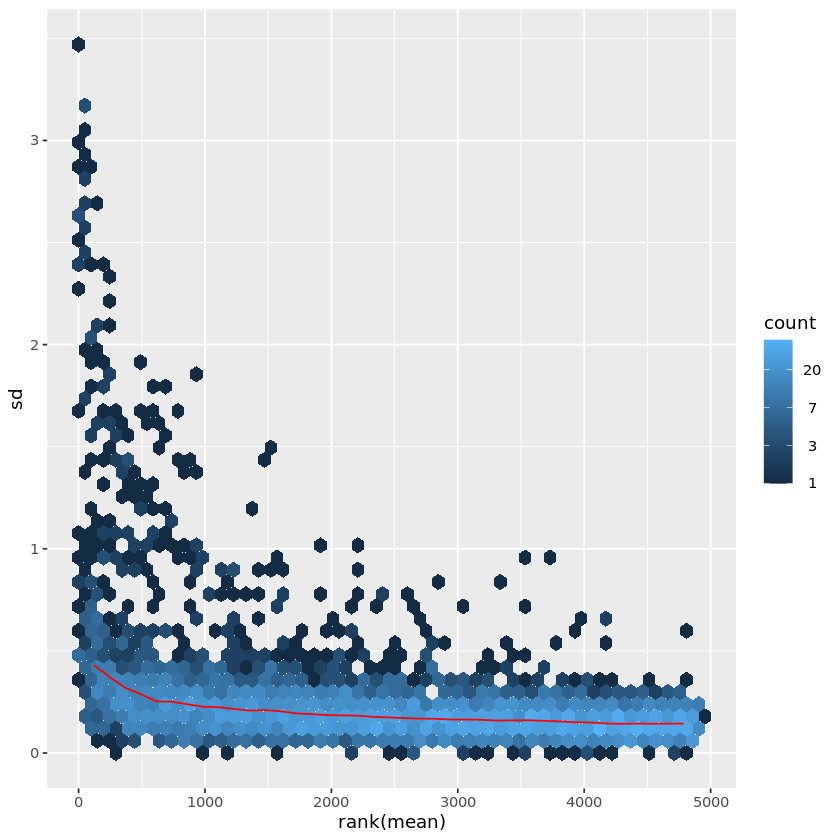

In [28]:
meanSdPlot(assay(ntd))

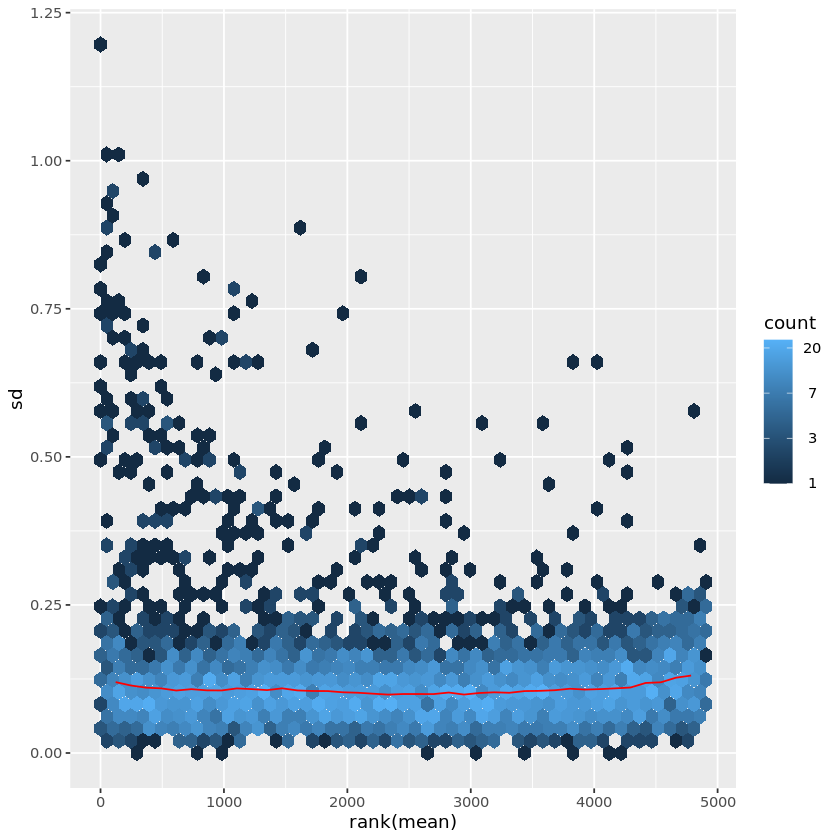

In [29]:
meanSdPlot(assay(vsd))

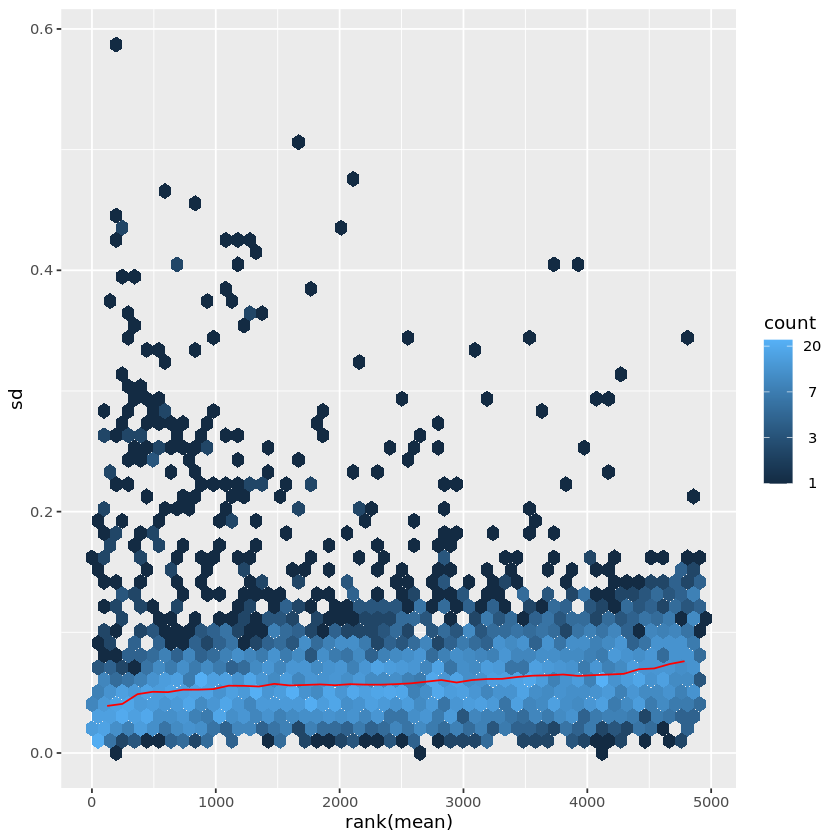

In [30]:
meanSdPlot(assay(rld))

#### PCA

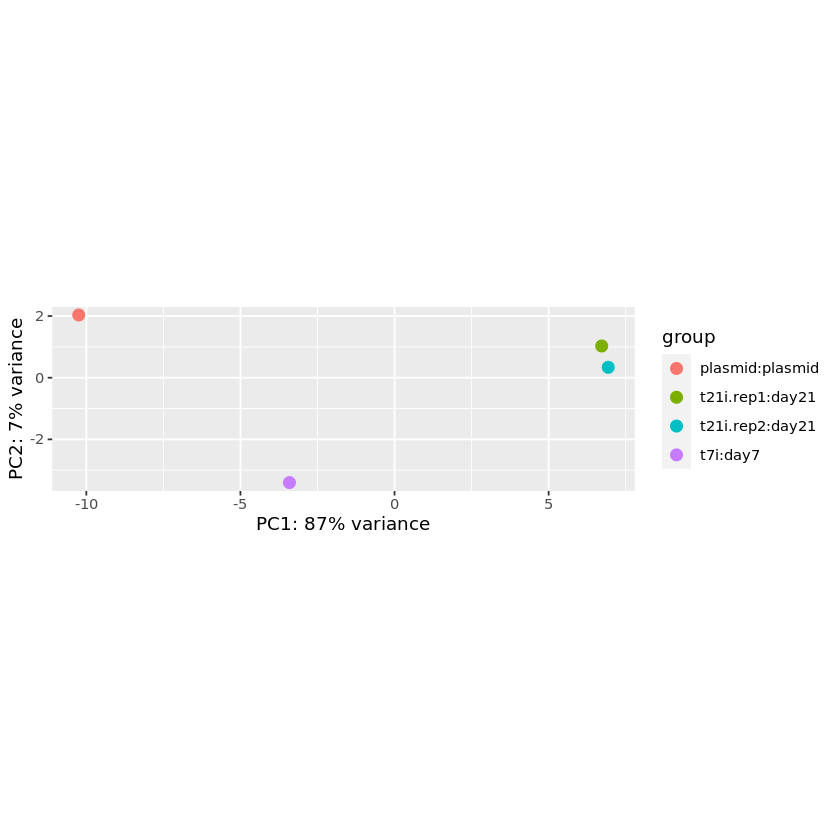

In [31]:
plotPCA(vsd, intgroup=c("sample", "group"))

#### Heatmap of sample-sample distance

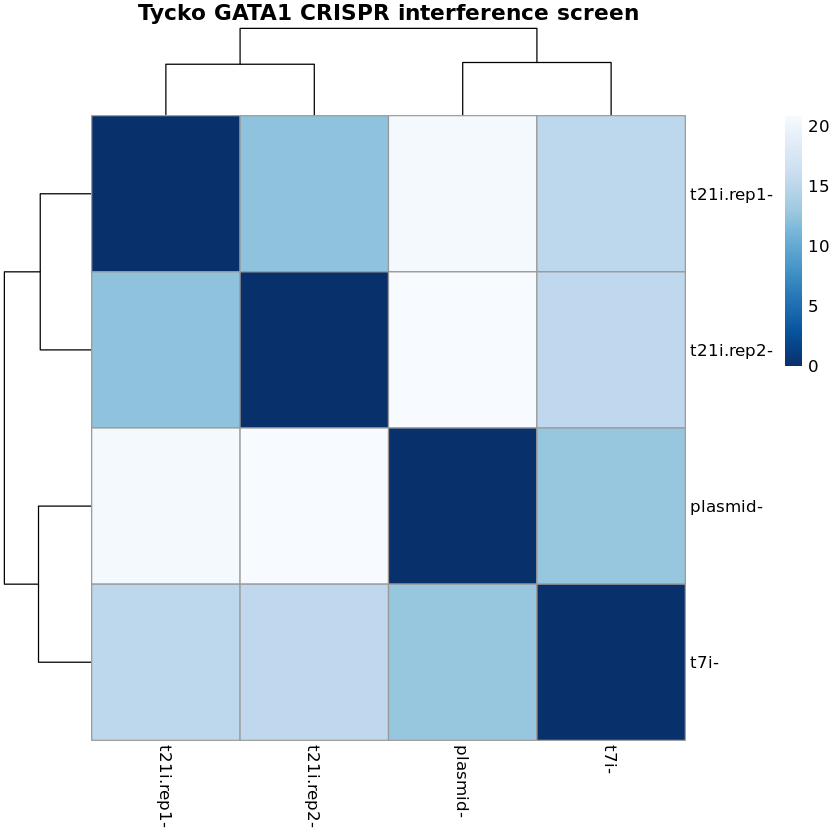

In [32]:
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$sample, vsd$type, sep="-")
colnames(sampleDistMatrix) <- paste(vsd$sample, vsd$type, sep="-") # change to 'NULL' to get rid of bottom labels
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors,
         main = "Tycko GATA1 CRISPR interference screen")

### Aggregate sgRNA-level effects to call "peaks"

In [1]:
suppressPackageStartupMessages(library(tidyverse))

#### Define fisher's method to aggregate p values
 - https://mikelove.wordpress.com/2012/03/12/combining-p-values-fishers-method-sum-of-p-values-binomial/
 - https://www.biostars.org/p/211307/

In [2]:
fishersMethod = function(x) pchisq(-2 * sum(log(x)),df=2*length(x),lower=FALSE)

#### Re-load results (if needed)

In [3]:
krab.res <- read_tsv("deseq2_results/removelowspec.tyckoGATA1krabinterference.deseq2.results.tsv",
                    show_col_types=FALSE)
head(krab.res,n=1)
dim(krab.res)

grna_id,type,d21.vs.plasmid.baseMean,d21.vs.plasmid.log2FoldChange,d21.vs.plasmid.lfcSE,d21.vs.plasmid.stat,d21.vs.plasmid.pvalue,d21.vs.plasmid.padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,230.629,-0.438347,0.3389427,-1.293278,0.195915,0.9999433


[1] 4908    8

#### Load output of bedtools intersect 

Defines "bins" and which sgRNAs belong to each bin after adjusting for perturbation modality.

In [4]:
peaks <- read.delim("grna_library/cutsite.tycko.krab.100step.bed", header = FALSE, 
                    col.names = c("grna.chrom","grna.start","grna.end","grna_id","bin.chr","bin.start","bin.end")) %>%
  mutate(bin = paste0(bin.chr,":",bin.start,"-",bin.end))

head(peaks,n=1)
dim(peaks)

,grna.chrom,grna.start,grna.end,grna_id,bin.chr,bin.start,bin.end,bin
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,chrX,48686619,48686621,chrX:48686620-48686623,chrX,48686400,48686500,chrX:48686400-48686500


[1] 36197     8

#### Subset DESeq2 results for only targeting sgRNAs

In [5]:
pam <- krab.res %>%
  filter(type == "tiling")

head(pam,n=1)
dim(pam)

grna_id,type,d21.vs.plasmid.baseMean,d21.vs.plasmid.log2FoldChange,d21.vs.plasmid.lfcSE,d21.vs.plasmid.stat,d21.vs.plasmid.pvalue,d21.vs.plasmid.padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,230.629,-0.438347,0.3389427,-1.293278,0.195915,0.9999433


[1] 4906    8

#### Number of significant bins (CREs) after removing low spec sgRNAs

In [6]:
length(
pam %>%
  left_join(peaks, by = "grna_id") %>%
  filter(grepl("chrX",bin)) %>%
  group_by(bin) %>%
  summarize(n = n(),
            fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
            mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
            max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
            bin.mid = (bin.end+bin.start)/2) %>%
  select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
  ungroup() %>%
  distinct() %>%
  mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
  mutate(sep = bin,
         sig = -log10(fdr)) %>%
  separate(sep, into = c("chrom","start","end")) %>%
  select(chrom, start, end, bin:sig) %>%
  filter(fdr < 0.1) %>%
  select(bin) %>%
  distinct() %>% pull()
       )

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


[1] 163

#### Filter for FDR < 0.1, write .bed files

In [7]:
pam %>%
  left_join(peaks, by = "grna_id") %>%
  filter(grepl("chrX",bin)) %>%
  group_by(bin) %>%
  summarize(n = n(),
            fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
            mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
            max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
            bin.mid = (bin.end+bin.start)/2) %>%
  select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
  ungroup() %>%
  distinct() %>%
  mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
  mutate(sep = bin,
         sig = -log10(fdr)) %>%
  separate(sep, into = c("chrom","start","end")) %>%
  select(chrom, start, end, bin:sig) %>%
  filter(fdr < 0.1) %>%
  mutate(strand = ".") %>%
  select(chrom:bin, sig, strand) %>%
  write.table("deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.adjp.hg38.bed", 
              col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


In [8]:
pam %>%
  left_join(peaks, by = "grna_id") %>%
  filter(grepl("chrX",bin)) %>%
  group_by(bin) %>%
  summarize(n = n(),
            fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
            mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
            max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
            bin.mid = (bin.end+bin.start)/2) %>%
  select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
  ungroup() %>%
  distinct() %>%
  mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
  mutate(sep = bin,
         sig = -log10(fdr)) %>%
  separate(sep, into = c("chrom","start","end")) %>%
  select(chrom, start, end, bin:sig) %>%
  filter(fdr < 0.1) %>%
  mutate(strand = ".") %>%
  select(chrom:bin, mean_logfc, strand) %>%
  write.table("deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.abslog2fc.hg38.bed", 
              col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


In [9]:
pam %>%
  left_join(peaks, by = "grna_id") %>%
  filter(grepl("chrX",bin)) %>%
  group_by(bin) %>%
  summarize(n = n(),
            fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
            mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
            max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
            bin.mid = (bin.end+bin.start)/2) %>%
  select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
  ungroup() %>%
  distinct() %>%
  mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
  mutate(sep = bin,
         sig = -log10(fdr)) %>%
  separate(sep, into = c("chrom","start","end")) %>%
  select(chrom, start, end, bin:sig) %>%
  filter(fdr < 0.1) %>%
  mutate(strand = ".") %>%
  select(chrom:bin, max_logfc, strand) %>%
  write.table("deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed", 
              col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")
 

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


### Switch to `python` kernel

#### Sort bins and then merge adjacent bins to generate final peak calls

In [1]:
%%bash
head -n 1 deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed
wc -l deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed


chrX	48696600	48696700	chrX:48696600-48696700	7.04791637476902	.
163 deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed


In [2]:
%%bash

sort -k1,1 -k2,2n deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed > deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed
head -n1 deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed
wc -l deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed

chrX	48696600	48696700	chrX:48696600-48696700	7.04791637476902	.
163 deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed


In [3]:
%%bash
module load bedtools2

bedtools merge -d 1 -i deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed > deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed

head -n 1 deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed
wc -l deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed

chrX	48696600	48697000
21 deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed


In [4]:
%%bash
wc -l /data/gersbachlab/lrb53/encodeCrisprWG/manuscript/deseq2/tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.bed

68 /data/gersbachlab/lrb53/encodeCrisprWG/manuscript/deseq2/tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.bed


The total peak count reduced from 68 to 21 peaks after removing the low spec guides. This suggests that the aggregation of DESeq2 approach is suspectible to false positives by low spec guides/off-target effects.

#### Intersect peak calls from other methods 

In [1]:
%%bash
module load bedtools2

bedtools multiinter -i /data/gersbachlab/lrb53/encodeCrisprWG/manuscript/gata1.commonregion.hg38.bed \
deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed \
/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/CASA__filtered_tycko_gata1_growth__replicatingPeaks.coords.bed \
/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/crisprsurf_significant_regions_corrected.merged.bed \
/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/mageck_filtered_Bassik_GATA1_CRISPRi_PLAvT21.merged.bed \
/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/bassik_crispri_gata1growth.removelowspec_RELICS_final_k1_FS_locations.sorted.merge.bed -header -names \
> upset/GATA1.tyckoCrispri.deseq2removelowpsec.txt

head upset/GATA1.tyckoCrispri.deseq2removelowpsec.txt

chrom	start	end	num	list	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/gata1.commonregion.hg38.bed	deseq2_peakcalls/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/CASA__filtered_tycko_gata1_growth__replicatingPeaks.coords.bed	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/crisprsurf_significant_regions_corrected.merged.bed	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/mageck_filtered_Bassik_GATA1_CRISPRi_PLAvT21.merged.bed	/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/newpeakcalls/bassik_crispri_gata1growth.removelowspec_RELICS_final_k1_FS_locations.sorted.merge.bed
chrX	48696600	48696667	1	2	0	1	0	0	0	0
chrX	48696667	48697000	2	2,4	0	1	0	1	0	0
chrX	48697000	48697047	1	4	0	0	0	1	0	0
chrX	48697067	48697227	1	4	0	0	0	1	0	0
chrX	48699800	48700200	1	2	0	1	0	0	0	0
chrX	48702727	48702867	1	4	0	0	0	1	0	0
chrX	48732248	48732404	1	6	0	0	0	0	0	1
chrX	48

### Change to `R`

### Load packages

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(UpSetR))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggplotify))

### Common region coordinates

In [2]:
commonregion <- read.delim("/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/gata1.commonregion.hg38.bed", header = FALSE,
                           col.names = c("chrom","start","end"))
head(commonregion)

,chrom,start,end
,<chr>,<int>,<int>
1,chrX,48745252,48821194


### Now, generate the upset plot

In [4]:
## Tycko KRAB (aggrDESeq2, CASA, CRISPR-SURF, MAGeCK, RELICS) 

df <- read.delim("upset/GATA1.tyckoCrispri.deseq2removelowpsec.txt", header = TRUE) %>%
  mutate(name = paste0(chrom,":",start,"-",end)) %>%
#   filter(chrom == commonregion$chrom) %>%
#   filter(start >= commonregion$start) %>%
#   filter(end <= commonregion$end) %>%
  rename(casa = `X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.newpeakcalls.CASA__filtered_tycko_gata1_growth__replicatingPeaks.coords.bed`,
         deseq2 = `deseq2_peakcalls.removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed`,
         surf = `X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.newpeakcalls.crisprsurf_significant_regions_corrected.merged.bed`,
         mageck =`X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.newpeakcalls.mageck_filtered_Bassik_GATA1_CRISPRi_PLAvT21.merged.bed`,
         relics = `X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.newpeakcalls.bassik_crispri_gata1growth.removelowspec_RELICS_final_k1_FS_locations.sorted.merge.bed`)

head(df,n=1)
dim(df)
colnames(df)

,chrom,start,end,num,list,X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.gata1.commonregion.hg38.bed,casa,deseq2,surf,mageck,relics,name
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,chrX,48696600,48696667,1,3,0,0,1,0,0,0,chrX:48696600-48696667


[1] 90 12

[1] "chrom"                                                                         
 [2] "start"                                                                         
 [3] "end"                                                                           
 [4] "num"                                                                           
 [5] "list"                                                                          
 [6] "X.data.gersbachlab.lrb53.encodeCrisprWG.manuscript.gata1.commonregion.hg38.bed"
 [7] "casa"                                                                          
 [8] "deseq2"                                                                        
 [9] "surf"                                                                          
[10] "mageck"                                                                        
[11] "relics"                                                                        
[12] "name"

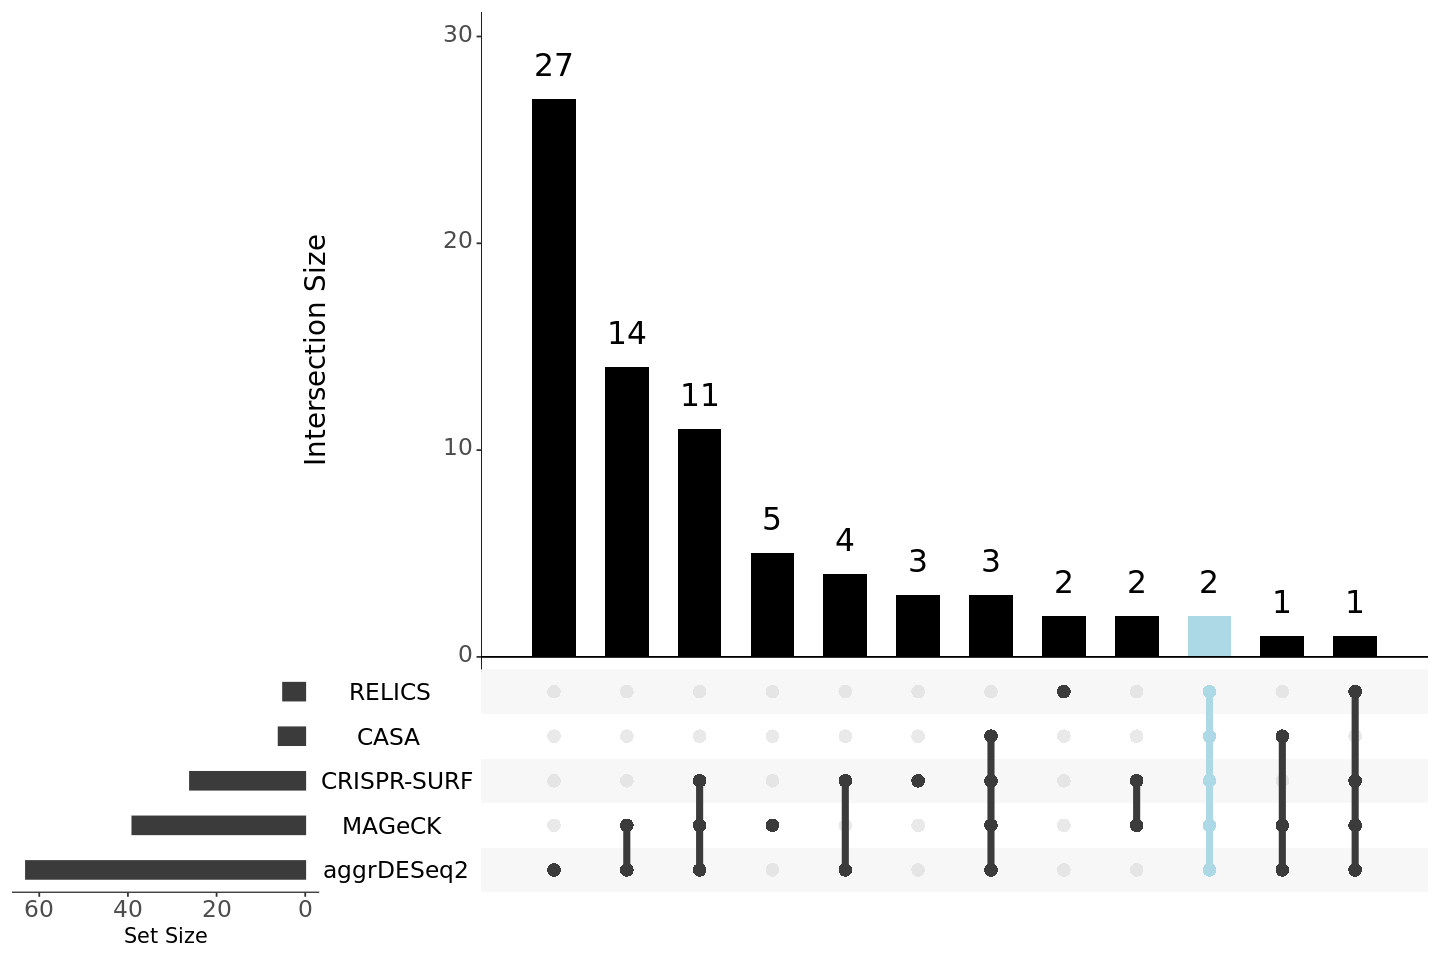

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8)
# region <- df %>% filter(commonregion_coords == 1) %>% select(name) %>% distinct() %>% pull()
screen1 <- df %>% filter(casa == 1) %>% select(name) %>% distinct() %>% pull()
screen2 <- df %>% filter(deseq2 == 1) %>% select(name) %>% distinct() %>% pull()
screen3 <- df %>% filter(surf == 1) %>% select(name) %>% distinct() %>% pull()
screen4 <- df %>% filter(mageck == 1) %>% select(name) %>% distinct() %>% pull()
screen5 <- df %>% filter(relics == 1) %>% select(name) %>% distinct() %>% pull()


# listInput <- list("common_region" = region, 
#                   "CASA" = screen1, 
#                   "aggrDESeq2" = screen2, 
#                   "CRISPR-SURF" = screen3, 
#                   "MAGeCK" = screen4, 
#                   "RELICS" = screen5
#                  )

listInput <- list("CASA" = screen1, 
                  "aggrDESeq2" = screen2, 
                  "CRISPR-SURF" = screen3, 
                  "MAGeCK" = screen4, 
                  "RELICS" = screen5
                 )

p9 <- upset(fromList(listInput), 
      order.by = "freq",
      nsets = 6,
      queries = list(list(query = intersects, params = list("CASA","aggrDESeq2","MAGeCK","CRISPR-SURF","RELICS"), color = "lightblue", active = T)),
      # set_size.show = TRUE, ### these do not look good when added in R, add later in Illustrator
      # set_size.numbers_size = 5,
      point.size = 3.5, 
      line.size = 2, 
      mainbar.y.label = "Intersection Size", 
      sets.x.label = "Set Size", 
      main.bar.color = "black", 
      text.scale = c(2, 2, 1.5, 2, 2, 3) # intersection size title, intersection size tick labels, set size title, set size tick labels, set names, numbers above bars
      ) 

p9

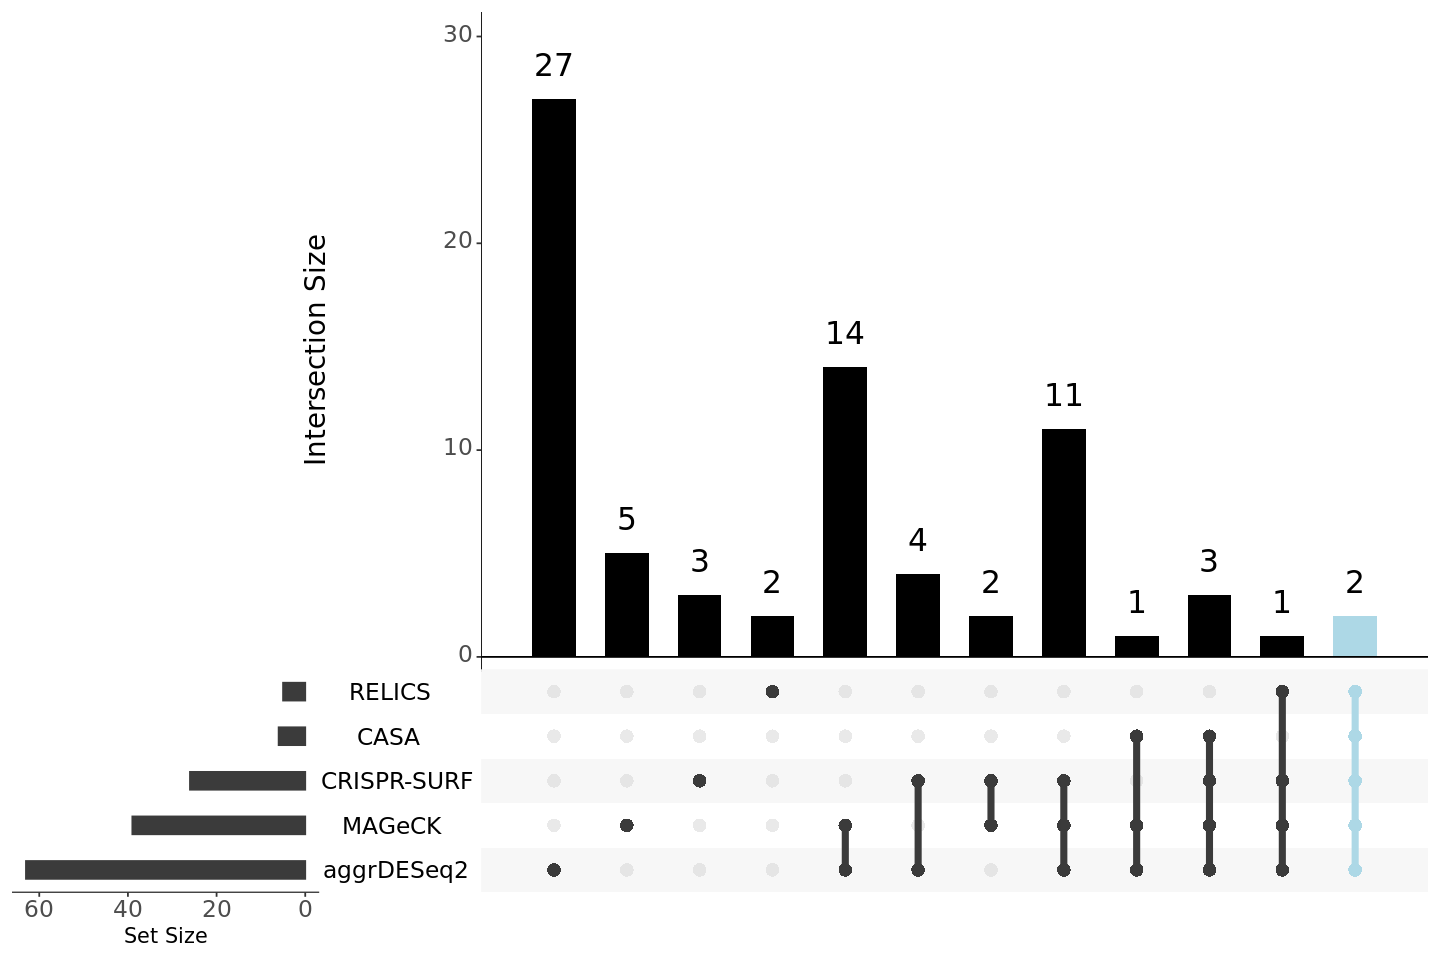

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8)
# region <- df %>% filter(commonregion_coords == 1) %>% select(name) %>% distinct() %>% pull()
screen1 <- df %>% filter(casa == 1) %>% select(name) %>% distinct() %>% pull()
screen2 <- df %>% filter(deseq2 == 1) %>% select(name) %>% distinct() %>% pull()
screen3 <- df %>% filter(surf == 1) %>% select(name) %>% distinct() %>% pull()
screen4 <- df %>% filter(mageck == 1) %>% select(name) %>% distinct() %>% pull()
screen5 <- df %>% filter(relics == 1) %>% select(name) %>% distinct() %>% pull()


# listInput <- list("common_region" = region, 
#                   "CASA" = screen1, 
#                   "aggrDESeq2" = screen2, 
#                   "CRISPR-SURF" = screen3, 
#                   "MAGeCK" = screen4, 
#                   "RELICS" = screen5
#                  )

listInput <- list("CASA" = screen1, 
                  "aggrDESeq2" = screen2, 
                  "CRISPR-SURF" = screen3, 
                  "MAGeCK" = screen4, 
                  "RELICS" = screen5
                 )

p9 <- upset(fromList(listInput), 
#       order.by = "freq",
      nsets = 6,
      queries = list(list(query = intersects, params = list("CASA","aggrDESeq2","MAGeCK","CRISPR-SURF","RELICS"), color = "lightblue", active = T)),
      # set_size.show = TRUE, ### these do not look good when added in R, add later in Illustrator
      # set_size.numbers_size = 5,
      point.size = 3.5, 
      line.size = 2, 
      mainbar.y.label = "Intersection Size", 
      sets.x.label = "Set Size", 
      main.bar.color = "black", 
      text.scale = c(2, 2, 1.5, 2, 2, 3) # intersection size title, intersection size tick labels, set size title, set size tick labels, set names, numbers above bars
      ) 

p9